In [137]:
import pandas as pd
import xlrd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

## Load and Clean Dataset

In [138]:
file = 'CaseStudy2data.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Load a sheet into a DataFrame by name: df1
unchanged_attrition_df = xl.parse('HR-employee-attrition Data')
attrition_df = unchanged_attrition_df

#drop unneccessary columns with constant values
attrition_column = attrition_df["Attrition"]
attrition_df.drop("Attrition", axis=1, inplace=True)
attrition_df.insert(0, "Attrition", attrition_column)
attrition_df.drop('EmployeeCount', axis=1, inplace=True)
attrition_df.drop('StandardHours', axis=1, inplace=True)
attrition_df.drop('Over18', axis=1, inplace=True)

#convert attrition variable to binary
attrition_df = attrition_df.replace("Yes", 1)
attrition_df = attrition_df.replace("No", 0)

# code dummy variables, this is necessary to use sklearn
attrition_df = pd.get_dummies(attrition_df, columns=["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus"], prefix=["BusinessTravel", "Department", "EduationField", "Gender", "JobRole", "MaritalStatus"])
df_without_attrition = attrition_df.drop("Attrition", axis=1)
columns_without_attrition = df_without_attrition.columns
columns_with_attrition = attrition_df.columns
attrition_df

Attrition  Age  DailyRate  DistanceFromHome  Education  EmployeeNumber  \
0             1   41       1102                 1          2               1   
1             0   49        279                 8          1               2   
2             1   37       1373                 2          2               4   
3             0   33       1392                 3          4               5   
4             0   27        591                 2          1               7   
5             0   32       1005                 2          2               8   
6             0   59       1324                 3          3              10   
7             0   30       1358                24          1              11   
8             0   38        216                23          3              12   
9             0   36       1299                27          3              13   
10            0   35        809                16          3              14   
11            0   29        153                15          2              15   
12            0   31        670                26          1              16   
13            0   34       1346                19          2              18   
14            1   28        103                24          3              19   
15            0   29       1389                21          4              20   
16            0   32        334                 5          2              21   
17            0   22       1123                16          2              22   
18            0   53       1219                 2          4              23   
19            0   38        371                 2          3              24   
20            0   24        673                11          2              26   
21            1   36       1218                 9          4              27   
22            0   34        419                 7          4              28   
23            0   21        391                15          2              30   
24            1   34        699                 6          1              31   
25            0   53       1282                 5          3              32   
26            1   32       1125                16          1              33   
27            0   42        691                 8          4              35   
28            0   44        477                 7          4              36   
29            0   46        705                 2          4              38   
30            0   33        924                 2          3              39   
31            0   44       1459                10          4              40   
32            0   30        125                 9          2              41   
33            1   39        895                 5          3              42   
34            1   24        813                 1          3              45   
35            0   43       1273                 2          2              46   
36            1   50        869                 3          2              47   
37            0   35        890                 2          3              49   
38            0   36        852                 5          4              51   
39            0   33       1141                 1          3              52   
40            0   35        464                 4          2              53   
41            0   27       1240                 2          4              54   
42            1   26       1357                25          3              55   
43            0   27        994                 8          3              56   
44            0   30        721                 1          2              57   
45            1   41       1360                12          3              58   
46            0   34       1065                23          4              60   
47            0   37        408                19          2              61   
48            0   46       1211                 5          4              62   
49    

## Split into Train and Test Set

In [139]:
rand = np.random.rand(len(attrition_df)) < 0.8

train = attrition_df[rand]
test = attrition_df[~rand]

print(train.shape)
print(test.shape)

(1168, 52)
(302, 52)


## Correlation Matrix to Identify Covariance

In [140]:
train.corr().abs()

Attrition       Age  DailyRate  \
Attrition                           1.000000  0.155826   0.046056   
Age                                 0.155826  1.000000   0.003375   
DailyRate                           0.046056  0.003375   1.000000   
DistanceFromHome                    0.088588  0.013674   0.014403   
Education                           0.036052  0.223852   0.018049   
EmployeeNumber                      0.028055  0.018957   0.025863   
EnvironmentSatisfaction             0.129580  0.014333   0.005418   
HourlyRate                          0.013861  0.001678   0.012991   
JobInvolvement                      0.134297  0.001859   0.054320   
JobLevel                            0.163875  0.505856   0.013463   
JobSatisfaction                     0.100267  0.010188   0.028107   
MonthlyIncome                       0.153659  0.498637   0.021971   
MonthlyRate                         0.014535  0.007958   0.023064   
NumCompaniesWorked                  0.050430  0.310374   0.043088   
OverTime                            0.258000  0.023234   0.020097   
PercentSalaryHike                   0.006131  0.007358   0.023077   
PerformanceRating                   0.014609  0.026803   0.000937   
RelationshipSatisfaction            0.041862  0.057175   0.005037   
StockOptionLevel                    0.137521  0.025441   0.044230   
TotalWorkingYears                   0.160543  0.675841   0.014326   
TrainingTimesLastYear               0.064993  0.010323   0.014374   
WorkLifeBalance                     0.081338  0.021278   0.042890   
YearsAtCompany                      0.124346  0.323800   0.024742   
YearsInCurrentRole                  0.152832  0.225792   0.015526   
YearsSinceLastPromotion             0.022058  0.230226   0.009433   
YearsWithCurrManager                0.146573  0.211558   0.016121   
BusinessTravel_Non-Travel           0.069847  0.035054   0.005455   
BusinessTravel_Travel_Frequently    0.114897  0.019503   0.003249   
BusinessTravel_Travel_Rarely        0.051364  0.040544   0.006494   
Department_Human Resources          0.009920  0.003118   0.017560   
Department_Research & Development   0.079482  0.004816   0.013821   
Department_Sales                    0.078089  0.006358   0.006653   
EduationField_Human Resources       0.036097  0.022141   0.033269   
EduationField_Life Sciences         0.012500  0.020205   0.004108   
EduationField_Marketing             0.059107  0.052668   0.062491   
EduationField_Medical               0.053243  0.009578   0.027368   
EduationField_Other                 0.017943  0.039275   0.000821   
EduationField_Technical Degree      0.044575  0.033942   0.029409   
Gender_Female                       0.018585  0.026115   0.002913   
Gender_Male                         0.018585  0.026115   0.002913   
JobRole_Healthcare Representative   0.083314  0.099874   0.033485   
JobRole_Human Resources             0.020728  0.020796   0.025277   
JobRole_Laboratory Technician       0.112993  0.154470   0.017360   
JobRole_Manager                     0.082185  0.285343   0.008058   
JobRole_Manufacturing Director      0.086200  0.039934   0.005480   
JobRole_Research Director           0.086615  0.184529   0.014841   
JobRole_Research Scientist          0.000059  0.151107   0.011219   
JobRole_Sales Executive             0.027669  0.014790   0.021335   
JobRole_Sales Representative        0.144651  0.164117   0.033200   
MaritalStatus_Divorced              0.082473  0.017937   0.055445   
MaritalStatus_Married               0.096301  0.085196   0.024565   
MaritalStatus_Single                0.176017  0.107068   0.075322   

                                   DistanceFromHome  Education  \
Attrition                                  0.088588   0.036052   
Age                                        0.013674   0.223852   
DailyRate                                  0.014403   0.018049   
DistanceFromHome                           1.000000   0.040443   
Education                                  0.04

Based off looking at the correlation matrix above, there are not any values that stand out as extremly correlated (0.8). Thus no variables will be removed.

## Recursive Feature Elimination

In [141]:
np.set_printoptions(precision=3)

values = train.values

X = values[:,1:(len(train.columns))]
Y = values[:,0]

test_values = test.values
X_test = test_values[:,1:(len(test.columns))]
Y_test = test_values[:,0]


number_of_features_to_select = 5
# feature extraction
model = LogisticRegression()
rfe = RFE(model, number_of_features_to_select)
fit = rfe.fit(X, Y)
print(fit.support_)
print(fit.ranking_)
true_indexes = [i for i, x in enumerate(fit.support_) if x == True]
features = np.asarray(columns_without_attrition[true_indexes])
print(features)

predictions = rfe.predict(X_test)
print('Accuracy of RFE on test set: {:.5f}'.format(fit.score(X_test, Y_test)))


[False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False  True  True  True False False False
 False False False]
[39 43 38 45 44 11 42  7 37 12 46 47 31  1 40 28 23 19 32 25 13 35 29 30
 34 15  6 10 22 21 20  4 27  8 26 24  9 18 17  1 14  5  1  1  1 36 16  3
 41 33  2]
['OverTime' 'JobRole_Healthcare Representative' 'JobRole_Manager'
 'JobRole_Manufacturing Director' 'JobRole_Research Director']
Accuracy of RFE on test set: 0.87086


## Feature Importance With ExtraTreesClassifier

In [142]:
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
model = ExtraTreesClassifier()
fit = model.fit(X, Y)

importances = model.feature_importances_
print(importances)

idxs = np.argsort(importances)[-(number_of_features_to_select):]
features = np.asarray(columns_without_attrition[idxs])
print(list(reversed(features.tolist())))

predictions = model.predict(X_test)
print('Accuracy of extra trees classifier on test set: {:.5f}'.format(model.score(X_test, Y_test)))


[0.03  0.024 0.032 0.019 0.025 0.036 0.027 0.028 0.025 0.032 0.03  0.025
 0.033 0.066 0.026 0.013 0.025 0.021 0.031 0.021 0.028 0.029 0.027 0.028
 0.027 0.006 0.02  0.015 0.005 0.009 0.009 0.003 0.012 0.012 0.014 0.008
 0.01  0.017 0.016 0.008 0.003 0.019 0.006 0.007 0.002 0.01  0.01  0.015
 0.01  0.016 0.028]
['OverTime', 'EnvironmentSatisfaction', 'NumCompaniesWorked', 'DistanceFromHome', 'JobSatisfaction']
Accuracy of extra trees classifier on test set: 0.89735


## Random Forrest

In [143]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X, Y)

clf.predict(X_test)

# preds = iris.target_names[clf.predict(test[features])]
train.describe()
test.describe()
preds = clf.predict_proba(X_test)

predictions = []
attrition_count = 0
not_attrition_count = 0
for pred in preds:
    if pred[0] >= pred[1]:
        not_attrition_count = not_attrition_count + 1
        predictions.append('No Attrition') 
    else:
        attrition_count = attrition_count + 1
        predictions.append('Attrition')
    
print("Attrition count: ")
print(attrition_count)
print("Not Attrition count: ")
print(not_attrition_count)
print('Accuracy of random forrest on test set: {:.5f}'.format(clf.score(X_test, Y_test)))
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), columns_without_attrition), reverse=True)[:5])



Attrition count: 
15
Not Attrition count: 
287
Accuracy of random forrest on test set: 0.87417
[(0.0819, 'MonthlyIncome'), (0.0674, 'Age'), (0.0616, 'OverTime'), (0.0481, 'HourlyRate'), (0.0418, 'DailyRate')]


## Logistic Regression

In [144]:
logreg = LogisticRegression()
logreg.fit(X, Y)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, Y_test)))


Accuracy of logistic regression classifier on test set: 0.89404


In [145]:
denom = (2.0*(1.0+np.cosh(logreg.decision_function(X))))
F_ij = np.dot((X/denom[:,None]).T,X) ## Fisher Information Matrix
Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
z_scores = logreg.coef_[0]/sigma_estimates # z-score for eaach model coefficient
p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values

print(sorted(list(zip(p_values, columns_without_attrition)))[:5])

[(1.8493636924919838e-09, 'OverTime'), (2.1444000743710956e-09, 'NumCompaniesWorked'), (6.540964092304083e-05, 'DistanceFromHome'), (9.02365063602836e-05, 'EnvironmentSatisfaction'), (0.0003564745303204413, 'YearsSinceLastPromotion')]


/Users/mihirparikh/.local/share/virtualenvs/case_study_two-VwQshxTY/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


## Investigating Possible Correlation

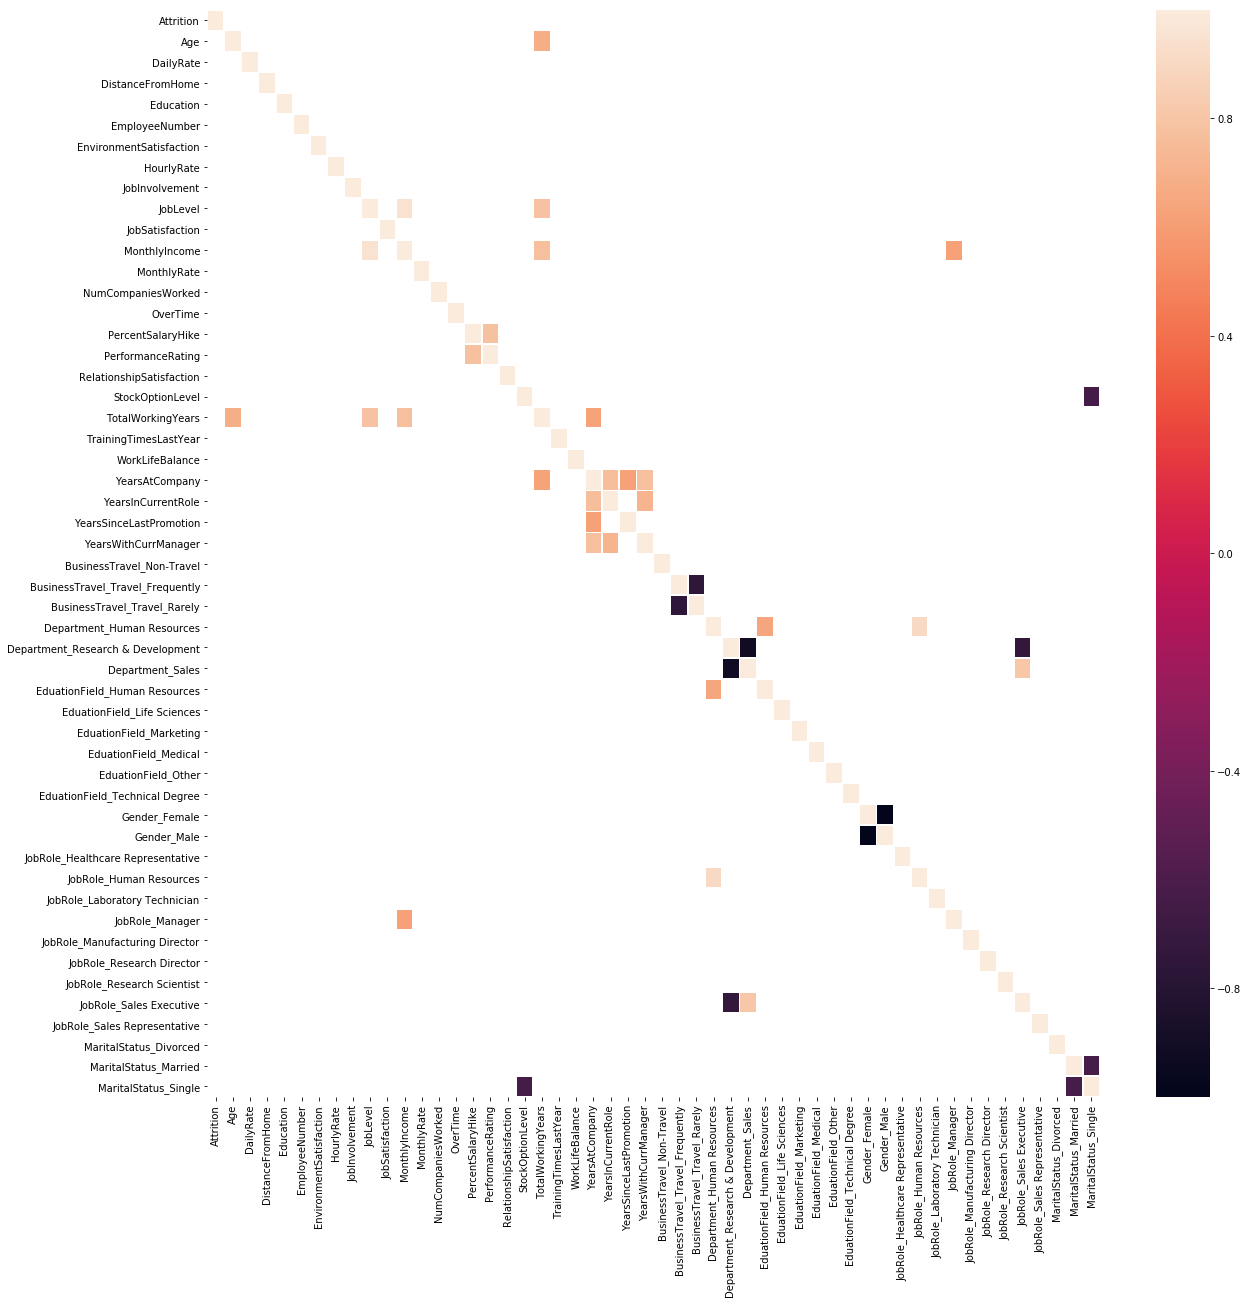

In [146]:
plt.figure(figsize = (20,20))
corr = attrition_df.corr()
sns.heatmap(corr[(corr >= 0.6) | (corr <= -0.6)], 
        xticklabels=columns_with_attrition,
        yticklabels=columns_with_attrition, linewidths=.6)

## Data Exploration

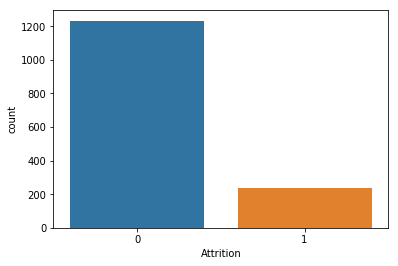

In [147]:
sns.countplot(x='Attrition',data=attrition_df)
plt.show()

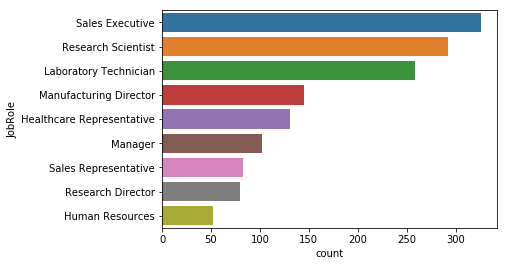

In [148]:
sns.countplot(y="JobRole", data=unchanged_attrition_df)
plt.show()

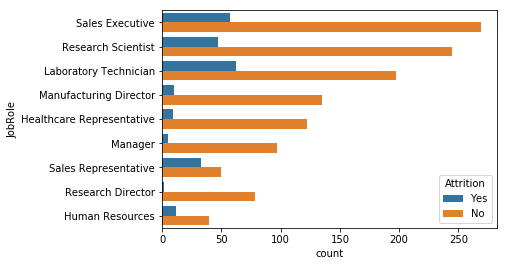

In [149]:
sns.countplot(y="JobRole", hue="Attrition", data=unchanged_attrition_df)

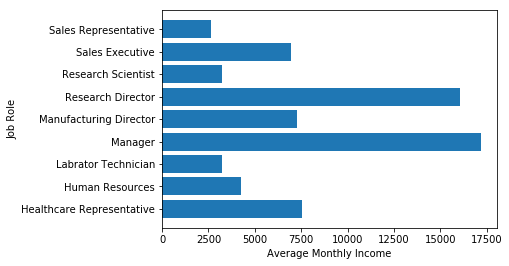

In [150]:
income = unchanged_attrition_df.groupby('JobRole').mean()[['MonthlyIncome']].values
flattened_income = []
for i in income:
    flattened_income.append(i[0])
    
roles = ['Healthcare Representative', 'Human Resources', 'Labrator Technician', 'Manager', 'Manufacturing Director', 'Research Director', 'Research Scientist' , 'Sales Executive','Sales Representative']

y_pos = np.arange(len(roles))

plt.xlabel('Average Monthly Income')
plt.ylabel('Job Role')
 
# Create horizontal bars
plt.barh(y_pos, flattened_income)
 
# Create names on the y-axis
plt.yticks(y_pos, roles)
 
# Show graphic
plt.show()

